<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/Hotel_CNN_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano' # Why theano why not
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

In [2]:
#Upload the Dataset
from google.colab import files
uploaded = files.upload()

Saving hotel_data_clean.csv to hotel_data_clean.csv


In [3]:
# Dataset is now stored in a Pandas Dataframe
import io
data = pd.read_csv(io.BytesIO(uploaded['hotel_data_clean.csv']))

In [4]:
data.head()

,Index,Hotel_id,Hotel,Title,Users,Reviews,Text_Clean,Rating,tokens,Sentiment,User_id
0,0,0,La Quinta,This hotel is a dump! Upon ch...,margierodriguez.mcqueen,This hotel is a dump! Upon checking in was tol...,hotel dump upon checking told place booked fol...,1.0,"['hotel', 'dump', 'upon', 'checking', 'told', ...",Negative,15400
1,1,1,The Point,How to Feel like you are truly Royalty!,DrThought,After having stayed at The Point for five days...,stayed point five days back june 2011 wife ele...,5.0,"['stayed', 'point', 'five', 'days', 'back', 'j...",Positive,3702
2,2,1,The Point,Not to be missed,Dushi110,The Point exceeds perfection. From the moment ...,point exceeds perfection moment arrive prepare...,5.0,"['point', 'exceeds', 'perfection', 'moment', '...",Positive,3738
3,3,1,The Point,The most amazing place....,GracieLouNY,My review is long overdue but I tell so many p...,review long overdue tell many people place fel...,5.0,"['review', 'long', 'overdue', 'tell', 'many', ...",Positive,4593
4,4,1,The Point,Lack of maintenance,Guillen,We were picked up from the airport in a car wh...,picked airport car vacuum cleaned long time mi...,2.0,"['picked', 'airport', 'car', 'vacuum', 'cleane...",Negative,4657


In [5]:
# Checking for missing values
pd.isnull(data).any()

Index         False
Hotel_id      False
Hotel         False
Title          True
Users         False
Reviews        True
Text_Clean     True
Rating         True
tokens        False
Sentiment     False
User_id       False
dtype: bool

In [6]:
#Filing the missing Review with 'na'
data['Reviews'] = data['Reviews'].fillna('').apply(str)
data['Title'] = data['Title'].fillna('').apply(str)
data['Text_Clean'] = data['Text_Clean'].fillna('').apply(str)

In [7]:
data = data.dropna()
data = data.reset_index(drop=True)
print('Shape of dataset ',data.shape)
print(data.columns)
print('No. of unique classes',len(set(data['Sentiment'])))

Shape of dataset  (24151, 11)
Index(['Index', 'Hotel_id', 'Hotel', 'Title', 'Users', 'Reviews', 'Text_Clean',
       'Rating', 'tokens', 'Sentiment', 'User_id'],
      dtype='object')
No. of unique classes 2


In [8]:
data['Sentiment'] = data['Sentiment'].apply(lambda x: 0 if x == 'Negative' else 1)


In [9]:
data.head(10)

,Index,Hotel_id,Hotel,Title,Users,Reviews,Text_Clean,Rating,tokens,Sentiment,User_id
0,0,0,La Quinta,This hotel is a dump! Upon ch...,margierodriguez.mcqueen,This hotel is a dump! Upon checking in was tol...,hotel dump upon checking told place booked fol...,1.0,"['hotel', 'dump', 'upon', 'checking', 'told', ...",0,15400
1,1,1,The Point,How to Feel like you are truly Royalty!,DrThought,After having stayed at The Point for five days...,stayed point five days back june 2011 wife ele...,5.0,"['stayed', 'point', 'five', 'days', 'back', 'j...",1,3702
2,2,1,The Point,Not to be missed,Dushi110,The Point exceeds perfection. From the moment ...,point exceeds perfection moment arrive prepare...,5.0,"['point', 'exceeds', 'perfection', 'moment', '...",1,3738
3,3,1,The Point,The most amazing place....,GracieLouNY,My review is long overdue but I tell so many p...,review long overdue tell many people place fel...,5.0,"['review', 'long', 'overdue', 'tell', 'many', ...",1,4593
4,4,1,The Point,Lack of maintenance,Guillen,We were picked up from the airport in a car wh...,picked airport car vacuum cleaned long time mi...,2.0,"['picked', 'airport', 'car', 'vacuum', 'cleane...",0,4657
5,5,1,The Point,Great Camp luxury,Julie F,"On the shore of Lake Saranac, this is a very l...",shore lake saranac luxurious peaceful place st...,5.0,"['shore', 'lake', 'saranac', 'luxurious', 'pea...",1,6049
6,6,1,The Point,Welcomed back!,SJFLondon,"We visited The Point two years ago, and decide...",visited point two years ago decided return 25t...,5.0,"['visited', 'point', 'two', 'years', 'ago', 'd...",1,10086
7,7,1,The Point,The most amazing week end!,Sarahbnyc83,I was lucky enough to spend 2 nights at The Po...,lucky enough spend 2 nights point last year fe...,5.0,"['lucky', 'enough', 'spend', '2', 'nights', 'p...",1,10306
8,8,1,The Point,The Point of it all,Szerzek,That is the name on one of their boats. And th...,name one boats essence philosophy gotten point...,5.0,"['name', 'one', 'boats', 'essence', 'philosoph...",1,11027
9,9,1,The Point,Throw back to the Gatsby Era - don't miss The ...,ellen00007,From the minute you arrive until the minute yo...,minute arrive minute sadly leave point treated...,5.0,"['minute', 'arrive', 'minute', 'sadly', 'leave...",1,13760


In [10]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string

In [11]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [12]:
pd.isnull(data).any()


Index         False
Hotel_id      False
Hotel         False
Title         False
Users         False
Reviews       False
Text_Clean    False
Rating        False
tokens        False
Sentiment     False
User_id       False
dtype: bool

In [13]:
#Filing the missing Review with 'na'
data['Reviews'] = data['Reviews'].fillna('').apply(str)
data['Title'] = data['Title'].fillna('').apply(str)
data['Text_Clean'] = data['Text_Clean'].fillna('').apply(str)

In [14]:
data = data.dropna()
data = data.reset_index(drop=True)
print('Shape of dataset ',data.shape)
print(data.columns)
print('No. of unique classes',len(set(data['Sentiment'])))


Shape of dataset  (24151, 11)
Index(['Index', 'Hotel_id', 'Hotel', 'Title', 'Users', 'Reviews', 'Text_Clean',
       'Rating', 'tokens', 'Sentiment', 'User_id'],
      dtype='object')
No. of unique classes 2


In [15]:
macronum=sorted(set(data['Sentiment']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

data['Sentiment']=data['Sentiment'].apply(fun)

In [16]:
texts = []
labels = []


for idx in range(data.Text_Clean.shape[0]):
    text = BeautifulSoup(data.Text_Clean[idx])
    texts.append(clean_str(str(text.get_text().encode())))

for idx in data['Sentiment']:
    labels.append(idx)

In [17]:

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 45777


In [18]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of Data Tensor: (24151, 1000)
Shape of Label Tensor: (24151, 2)


In [19]:
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2020-09-05 05:14:48--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-09-05 05:14:49--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-09-05 05:14:49--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [20]:
!unzip glove*.zip


Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [21]:
!ls
!pwd

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip	    sample_data
glove.6B.200d.txt  glove.6B.50d.txt   hotel_data_clean.csv
/content


In [22]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d..' % len(embeddings_index))

Indexing word vectors.
Total 400000 word vectors in Glove 6B 100d..


In [23]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

In [24]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(len(macronum), activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)


Simplified convolutional neural network
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 100)         4577800   
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 199, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_2 (Conv

In [25]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=7, batch_size=32,callbacks=[cp])


Epoch 1/7
604/604 [==============================] - ETA: 0s - loss: 0.4160 - acc: 0.8242
Epoch 00001: val_acc improved from -inf to 0.84886, saving model to model_cnn.hdf5
604/604 [==============================] - 240s 397ms/step - loss: 0.4160 - acc: 0.8242 - val_loss: 0.3647 - val_acc: 0.8489
Epoch 2/7
604/604 [==============================] - ETA: 0s - loss: 0.3113 - acc: 0.8717
Epoch 00002: val_acc improved from 0.84886 to 0.86460, saving model to model_cnn.hdf5
604/604 [==============================] - 240s 397ms/step - loss: 0.3113 - acc: 0.8717 - val_loss: 0.3271 - val_acc: 0.8646
Epoch 3/7
604/604 [==============================] - ETA: 0s - loss: 0.2228 - acc: 0.9121
Epoch 00004: val_acc did not improve from 0.86460
604/604 [==============================] - 239s 395ms/step - loss: 0.2228 - acc: 0.9121 - val_loss: 0.3682 - val_acc: 0.8534
Epoch 5/7
604/604 [==============================] - ETA: 0s - loss: 0.1624 - acc: 0.9375
Epoch 00005: val_acc did not improve from 0.86

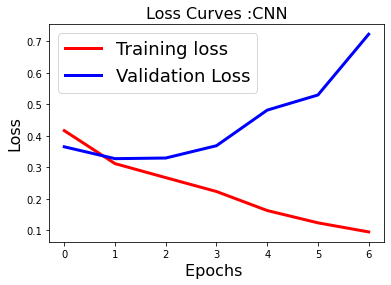

In [26]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

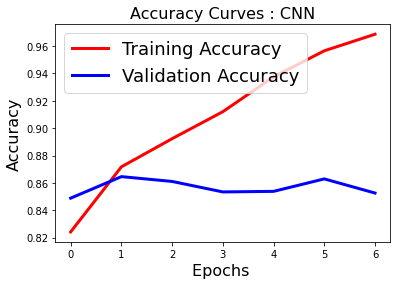

In [27]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

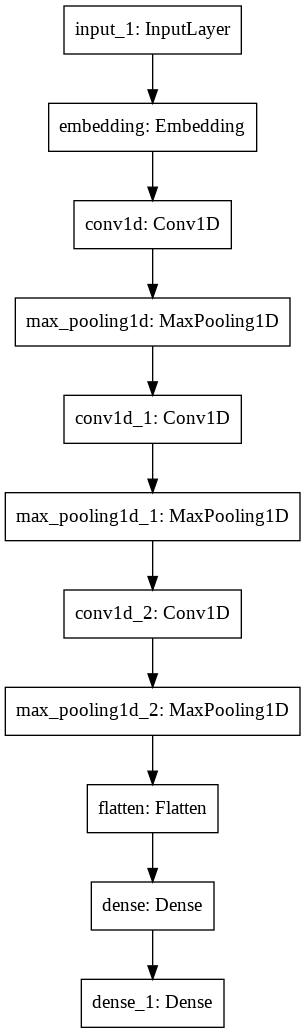

In [28]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='cnn_model.png')